# FOPDT identification

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

import package_DBR
from package_DBR import myRound, FOPDT, FOPDT_cost

# Load data

In [18]:
# nameFile = 'Open_loop_experiment_on_DV_2021-06-09-09h39.txt'
nameFile = 'Open_loop_experiment_on_MV_2022-04-27-11h01.txt'

if 'MV' in nameFile:
    ExpVariable = 'MV'
else:    
    ExpVariable = 'DV'
    
print(ExpVariable)    
    
titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)
t = data['t'].values - data['t'].values[0]
MV = data['MV'].values
PV = data['PV'].values
DV = data['DV'].values

MV


# Plot loaded data

(45.0, 55.0)

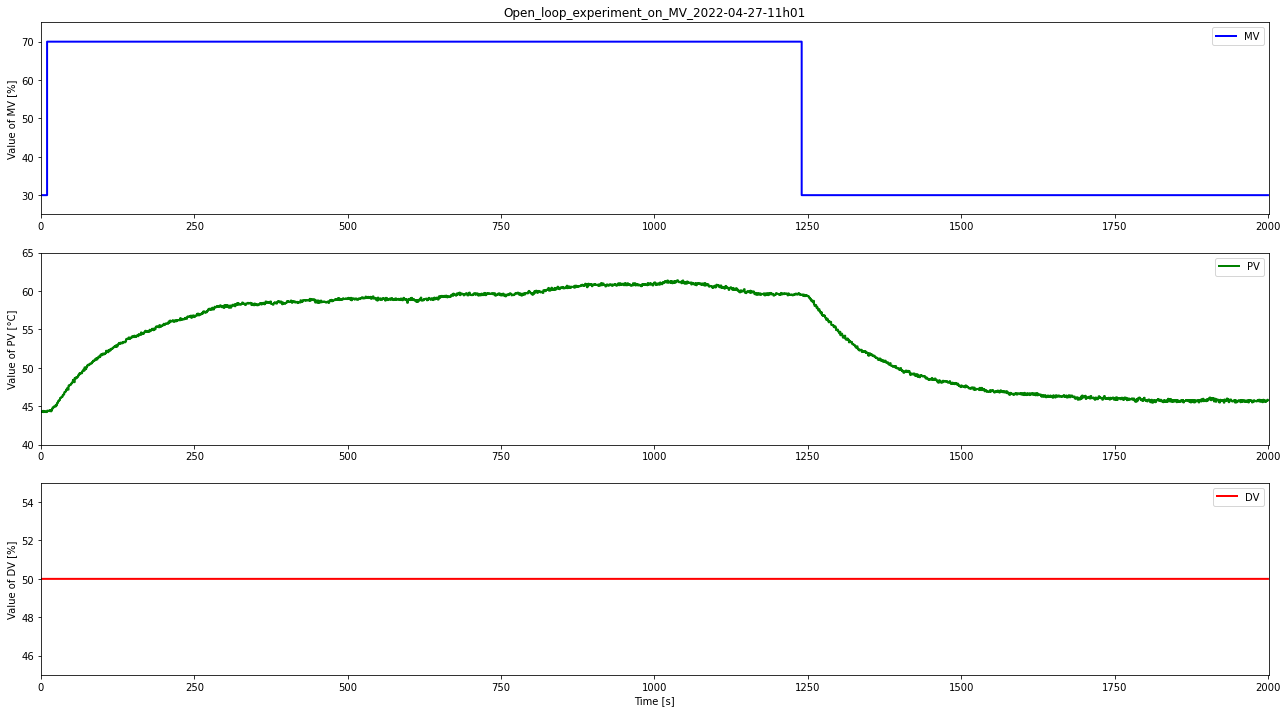

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title(titleName)
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')

l1.set_data(t,MV)
l2.set_data(t,PV)
l3.set_data(t,DV)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)
ax3.set_xlim(0, t[-1]+1)

ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)

# Clean data

In [20]:
if ExpVariable == 'MV':
    tstep = np.argwhere(np.diff(MV) != 0)
    tstep = tstep[0][0]
    tm = t[tstep:]
    tm = tm - tm[0]    
    MVstep = MV[tstep + 1] - MV[tstep]
    MVm = MV[tstep:]
    PVm = PV[tstep:]
    PVm = (PVm - PVm[0])/MVstep
    MVm = (MVm - MVm[0])/MVstep    
else:    
    tstep = np.argwhere(np.diff(DV) != 0)
    tstep = tstep[0][0]
    tm = t[tstep:]
    tm = tm - tm[0]
    DVstep = DV[tstep + 1] - DV[tstep]    
    DVm = DV[tstep:]
    PVm = PV[tstep:]
    PVm = (PVm - PVm[0])/DVstep
    DVm = (DVm - DVm[0])/DVstep

# Plot cleaned data

(0.0, 2001.0)

<Figure size 1584x1584 with 0 Axes>

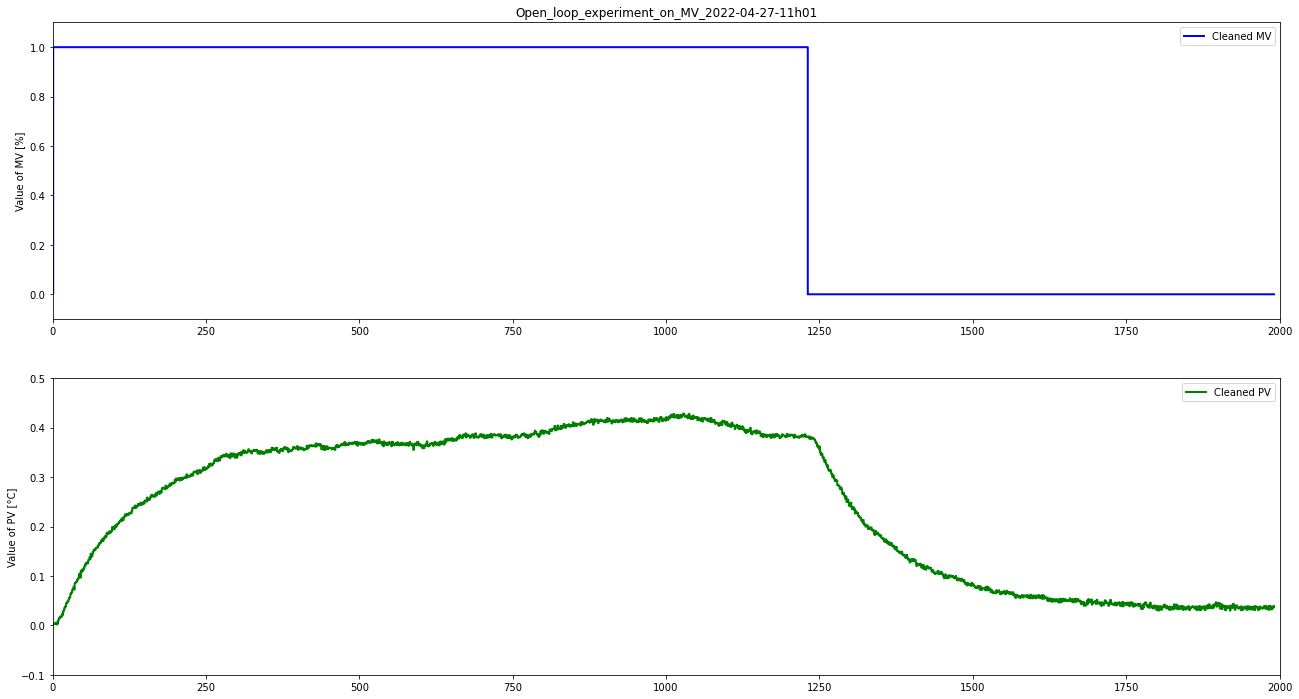

In [21]:
plt.figure(figsize = (22,22))

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(12)
fig.set_figwidth(22)

if ExpVariable == 'MV':
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned MV',where='post')
    ax1.set_ylabel('Value of MV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,MVm)
    ax1.set_ylim(myRound(np.min(MVm),1)-0.1, myRound(np.max(MVm),1)+0.1)    
else:
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned DV',where='post')
    ax1.set_ylabel('Value of DV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,DVm)
    ax1.set_ylim(myRound(np.min(DVm),1)-0.1, myRound(np.max(DVm),1)+0.1)     

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='Cleaned PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')
l2.set_data(tm,PVm)
ax2.set_ylim(myRound(np.min(PVm),0.1)-0.1, myRound(np.max(PVm),0.1)+0.1)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)

# Optimisation parameters

In [22]:
Ts = 1.0

maxIter = 500

p0 = np.zeros(3)
p0[0] = 0.5 # K
p0[1] = 100.0 # T
p0[2] = 10.0 # theta

bnds = ((None, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost = FOPDT_cost(p0,MVm,PVm,Ts)
else:
    cost = FOPDT_cost(p0,DVm,PVm,Ts)
    
print('Initial cost: ' + str(cost))

Initial cost: 16.819481977370906


# Optimisation

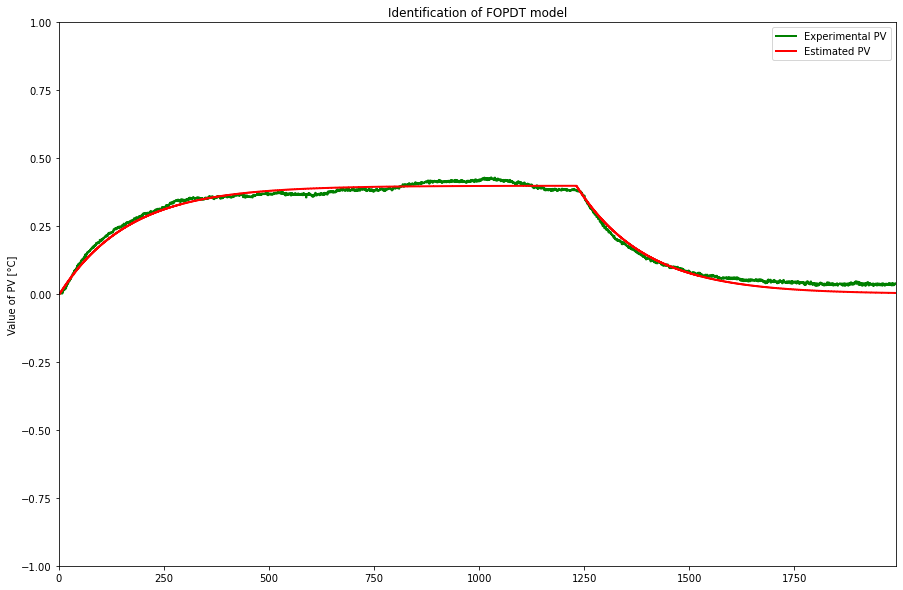

Final SSE Objective: 0.5617542772626348
K: 0.39830673728121035
T: 162.96308377413766
theta: 0.2712691970121537


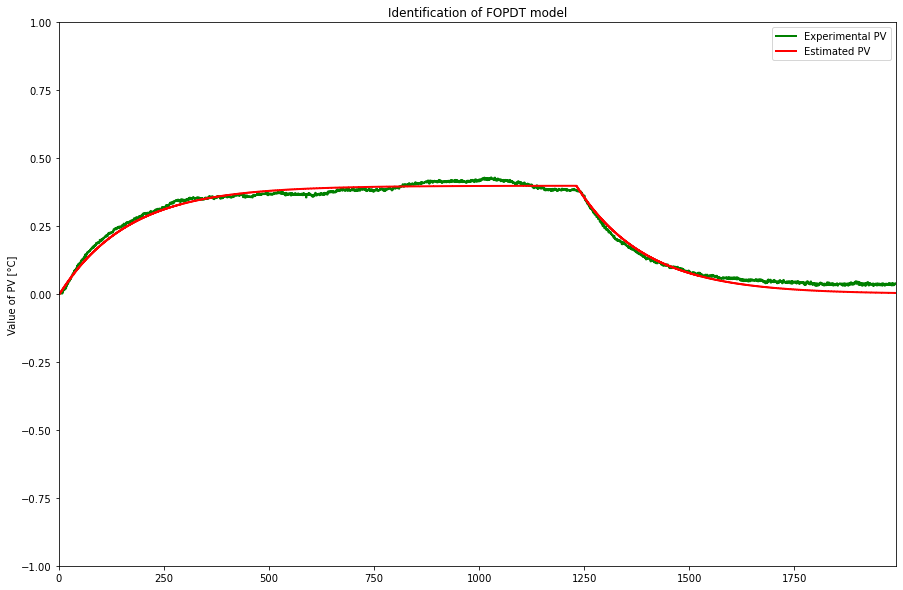

In [23]:
# optimize K, T, theta

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
l1, = ax1.step([0,1],[0,1],'g-',linewidth=2,label='Experimental PV',where='post')
l2, = ax1.step([0,1],[0,1],'r-',linewidth=2,label='Estimated PV',where='post')
ax1.set_ylabel('Value of PV [°C]')
ax1.set_title('Identification of FOPDT model')
ax1.legend(loc='best')

if ExpVariable == 'MV':
    solution = minimize(FOPDT_cost,p0,args=(MVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
    p = solution.x
    print('Final SSE Objective: ' + str(FOPDT_cost(p,MVm,PVm,Ts)))
else:
    solution = minimize(FOPDT_cost,p0,args=(DVm,PVm,Ts,(fig,ax1,l1,l2)), method='Powell',bounds=bnds,options={'maxiter': maxIter})    
    p = solution.x
    print('Final SSE Objective: ' + str(FOPDT_cost(p,DVm,PVm,Ts)))

K = p[0]
T = np.max([0,p[1]])
theta  = np.max([0,p[2]])

print('K: ' + str(K))
print('T: ' + str(T))
print('theta: ' + str(theta))    

# Plot experimental and simulated data

(0.0, 2000.0)

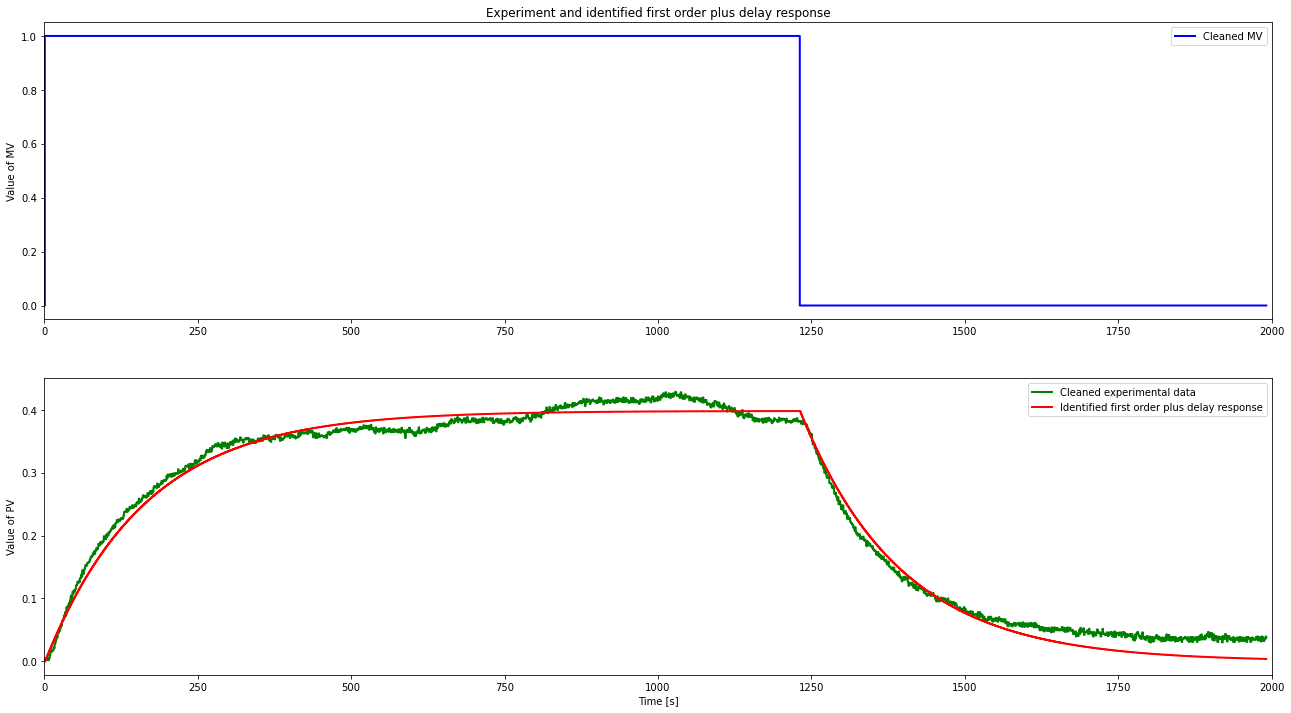

In [24]:
if ExpVariable == 'MV':
    PVSim = FOPDT(MVm,K,T,theta,Ts)
else:
    PVSim = FOPDT(DVm,K,T,theta,Ts)    

plt.figure(figsize = (22,12))

plt.subplot(2,1,1)
if ExpVariable == 'MV':
    plt.step(tm,MVm,'b-',linewidth=2,label='Cleaned MV',where='post')
    plt.ylabel('Value of MV')
else:
    plt.step(tm,DVm,'b-',linewidth=2,label='Cleaned DV',where='post')
    plt.ylabel('Value of DV') 
    
plt.title('Experiment and identified first order plus delay response')
plt.legend(loc='best')
plt.xlim([0, t[-1]])

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',linewidth=2,label='Cleaned experimental data',where='post')
plt.step(tm,PVSim,'r-',linewidth=2,label='Identified first order plus delay response',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, t[-1]])